In [1]:
# --- 1. Install and Import ---
# We run the installation quietly with `-q`
!pip install -q medmnist

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18
import medmnist
from medmnist import INFO, Evaluator
from tqdm import tqdm

print(f"Successfully imported libraries. Using MedMNIST version: {medmnist.__version__}")

# in the old style, I would use "print("Successfully imported libraries. Using MedMNIST version: %s" % (medmnist.__version__))"

# --- 2. Setup Dataset and Dataloaders ---

data_flag = 'breastmnist'
print(f"INFO: The data_flag is set to: '{data_flag}'") # Debug print

BATCH_SIZE = 128
download = True

# Get dataset information from the medmnist library
info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

# Define transformations to apply to the images
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load the datasets using the predefined splits and apply the transformations
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# Create DataLoaders to handle batching and shuffling
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("INFO: Datasets and Dataloaders are ready.")

# --- 3. Define and Prepare the Model ---
# Use ResNet-18 and train from scratch (pretrained=False)
model = resnet18(pretrained=False)

# Adjust the model for our specific dataset (1-channel grayscale images)
model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# Adjust the final layer for our number of classes (2 for BreastMNIST)
model.fc = nn.Linear(model.fc.in_features, n_classes)

# Move the model to the GPU if one is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"INFO: ResNet-18 model is defined and moved to device: {device}")

# --- 4. Define Loss, Optimizer, and Training Parameters ---
NUM_EPOCHS = 3 # Set to a low number for a quick test. Increase to 100 for full replication.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print(f"INFO: Starting training for {NUM_EPOCHS} epochs...")

# --- 5. Training and Validation Loop ---
for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Train]"):
        inputs, targets = inputs.to(device), targets.to(device).squeeze().long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    y_true_val, y_score_val = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_true_val.extend(targets.squeeze().tolist())
            y_score_val.extend(outputs.softmax(dim=-1).cpu().numpy())

    # convert the list of arrays into a single NumPy array
    y_score_val = np.vstack(y_score_val)

    # Calculate validation metrics
    val_evaluator = Evaluator(data_flag, 'val')
    metrics = val_evaluator.evaluate(y_score_val)
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Validation AUC: {metrics[0]:.3f}, Accuracy: {metrics[1]:.3f}")

print("\nINFO: Training complete!")

# --- 6. Final Evaluation on Test Set ---
print("INFO: Evaluating model on the final test set...")
model.eval()
y_true_test, y_score_test = [], []
with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="[Test]"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_true_test.extend(targets.squeeze().tolist())
        y_score_test.extend(outputs.softmax(dim=-1).cpu().numpy())

y_score_test = np.vstack(y_score_test)

# Calculate final test metrics
test_evaluator = Evaluator(data_flag, 'test')
test_auc, test_acc = test_evaluator.evaluate(y_score_test)

print("-" * 30)
print(f"Final Test Results for ResNet-18:")
print(f"Test AUC: {test_auc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")
print("-" * 30)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 5.7 MB/s eta 0:00:00
Successfully imported libraries. Using MedMNIST version: 3.0.2
INFO: The data_flag is set to: 'breastmnist'


100%|██████████| 560k/560k [00:00<00:00, 658kB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


INFO: Datasets and Dataloaders are ready.
INFO: ResNet-18 model is defined and moved to device: cuda:0
INFO: Starting training for 3 epochs...


Epoch 1/3 [Train]: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Epoch 1/3 - Validation AUC: 0.662, Accuracy: 0.731


Epoch 2/3 [Train]: 100%|██████████| 5/5 [00:00<00:00, 26.28it/s]


Epoch 2/3 - Validation AUC: 0.642, Accuracy: 0.731


Epoch 3/3 [Train]: 100%|██████████| 5/5 [00:00<00:00, 26.67it/s]


Epoch 3/3 - Validation AUC: 0.679, Accuracy: 0.744

INFO: Training complete!
INFO: Evaluating model on the final test set...


[Test]: 100%|██████████| 2/2 [00:00<00:00, 35.56it/s]

------------------------------
Final Test Results for ResNet-18:
Test AUC: 0.664
Test Accuracy: 0.724
------------------------------


INFO: {'pathmnist': {'python_class': 'PathMNIST', 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.', 'url': 'https://zenodo.org/records/10519652/files/pathmnist.npz?download=1', 'MD5': 'a8b06965200029087d5bd730944a56c1', 'url_64': 'https://zenodo.org/records/10519652/files/pathmnist_64.npz?download=1', 'MD5_64': '55aa9c1e0525abe5a6b9d8343a507616', 'url_128': 'https://zenodo.org/records/10519652/files/pathmnist_128.npz?down

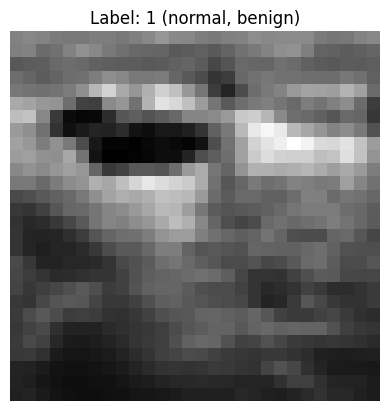

In [4]:
# !pip install -q medmnist
# Import necessary libraries
# import numpy as np

# import medmnist
# from medmnist import INFO

import matplotlib.pyplot as plt

# Download and load the dataset
data_flag = 'breastmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

print(f"INFO: {INFO}")

print(f"Data Class: {DataClass}")
print(f"Info: {info}")

train_dataset = DataClass(split='train', download=True)

# Get the first image (as a PIL Image) and its label
pil_image, label = train_dataset[1]

# --- THE FIX ---
# Convert the PIL Image to a NumPy array
image = np.array(pil_image)

# --- Inspect the data (This section will now work correctly) ---
print(f"Image Data Type: {type(image)}")
print(f"Image Shape: {image.shape}")
print(f"Label Data Type: {type(label)}")
print(f"Label Value: {label}")

# --- Visualize the data ---
# Get the metadata to translate the label
label_name = info['label'][str(label[0])]

# Plot the image using matplotlib
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label[0]} ({label_name})")
plt.axis('off') # Hide the grid and axes
plt.show()